In [1]:
import pickle
from sklearn.cluster import KMeans
import os
import cv2
import glob
from keras.models import load_model
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from keras.preprocessing import image 

#### Loading the model saved during training, trained_codes. The trained_codes are the output of encoder layer for all the training images which is saved while testing

In [2]:
trained_codes = pickle.load(open('train_codes.sav', 'rb'))

In [3]:
autoencoder = load_model('autoencoder_test_2.h5')
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output) 

In [4]:
width=224 #reshaping the image to 224*224 image
height=224

In [5]:
PATH = os.getcwd() 
train_path = PATH+'/dataset/' #path of the dataset

#### Below function gives us the filename as label of the image

In [6]:
def get_label(name):
    if name:
        img_name = name.split("/dataset/")
        img_name = img_name[1].split(".jpg")
        return img_name[0]
    return None

#### Saving all the labels of the images in a list "labels"

In [7]:
img_path = './dataset/*.jpg'
images = glob.glob(img_path)
labels = []
k=0
for img in images:
    # get the image file name and set it as the label
    label_id = get_label(img)
    labels.append(label_id)
    k += 1

### Kmeans clustering:
The trained codes loaded above are flattened and are given as input for k means clustering algorithm with 8 clusters

In [8]:
kmeans_input=[]
for i in trained_codes:
    kmeans_input.append(i.flatten())

In [9]:
kmeans = KMeans(n_clusters=8, random_state=0).fit(kmeans_input)
kmeans_labels=kmeans.labels_
print(kmeans_labels)

[5 2 6 ... 0 4 0]


In [10]:
kmeans_set=list(set(kmeans_labels)) #taking the unique numbers from the kmeans labels produced

### Below function is used for plotting the images in a grid format (sub plots)

In [11]:
def plot_images(result):
    w=20
    h=20
    fig=plt.figure(figsize=(50, 50))
    columns = 3
    rows = ceil(len(result)/columns)
    for i in range(1, columns*rows +1):
        if i==len(result)+1:
            break
        temp=str(result[i-1])+".jpg"
        img_path = train_path+temp 
        x = image.load_img(img_path)
        fig.add_subplot(rows, columns, i)
        #plt.axis("off")
        plt.imshow(x)
    plt.show()

### Below function is used to display top N images of all the clusters/selected clusters

In [12]:
def display_cluster_images(kmeans_labels,labels,pred=kmeans_set,N=10):
    for i in pred:
        print("for cluster"+str(kmeans_set[i]))
        kmeans_result=[]
        n=0
        for j in range(len(kmeans_labels)):
            if i==kmeans_labels[j]:
                kmeans_result.append(labels[j])
                n+=1
                if n==N:
                    break
    plot_images(kmeans_result)

### kmeans_clustering_test:
The below function accepts image path or image name as input reads the image, normalizes it and predicts the output of encoder layer of the model. The output of the encoder layer is flattened and given as input to k means clustering model which predicts the cluster number to which the given image belongs to. It further calls display_cluster_images function to display top N images of that cluster

In [13]:
def kmeans_clustering_test(train_path,image_name,width,height,N=10):
    if len(image_name)<=4:
        img_path = train_path+image_name+".jpg" 
    else:
        img_path=image_name
    img = cv2.imread(img_path)
    #when cv2 read the image it it converted to BGR image so to display the original image again converting back to RGB
    img_display = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img_display)   
    img = cv2.resize(img, (width, height), interpolation=cv2.INTER_CUBIC)
    img_lbl = get_label(img_path) # get the label
    x_test=np.array(img, dtype=np.float32)/255. #normalize the image
    x_test =np.expand_dims(x_test, axis=0)
    y_test = img_lbl
    predict_codes = encoder.predict(x_test) #predict the output of the encoding layer
    predict_codes= predict_codes.flatten() #flattening
    predict_codes=np.reshape(predict_codes,(-1,len(predict_codes)))
    predict_codes = predict_codes.astype(np.float64)
    pred=kmeans.predict(predict_codes)
    print("The below image belongs to cluster "+str(pred))
    display_cluster_images(kmeans_labels,labels,pred,N)
    

enter a number from 1 to 100 or give the path of the image:8
The below image belongs to cluster [7]
for cluster7


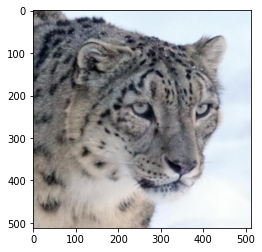

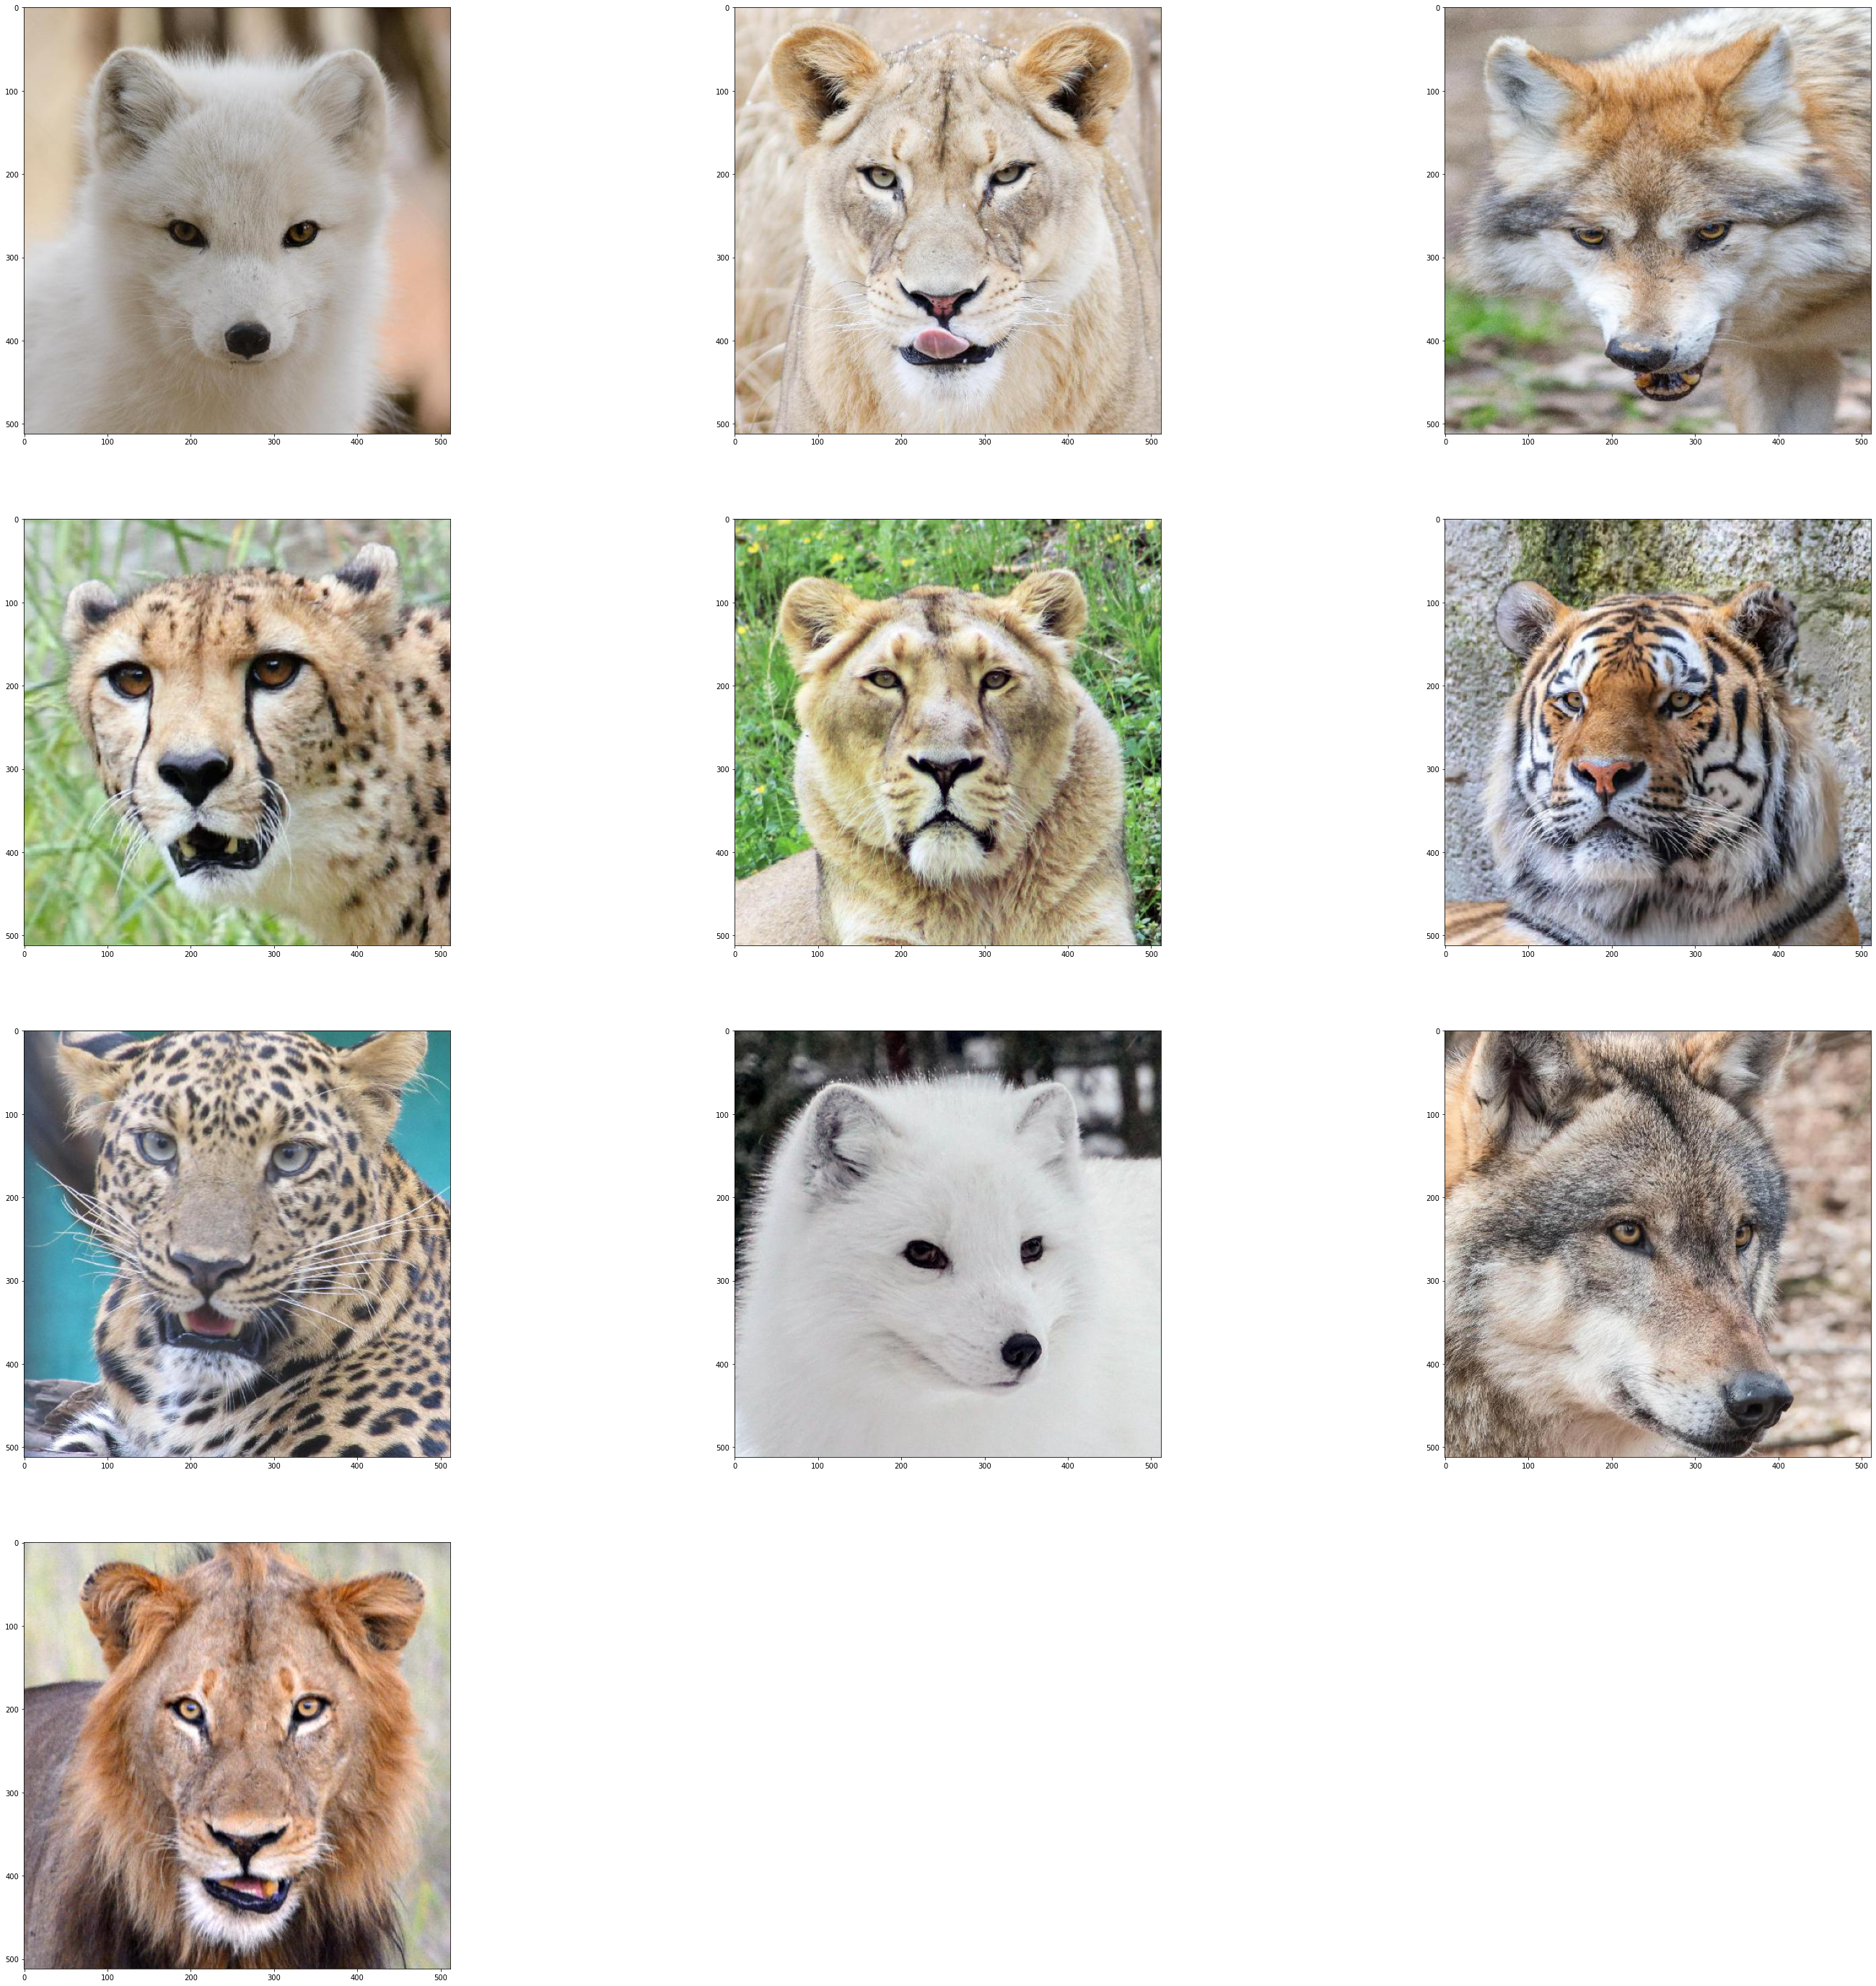

In [14]:
N=10
image_name=input("enter a number from 1 to 100 or give the path of the image:")
kmeans_clustering_test(train_path,image_name,width,height,N)